JAX detected devices: [CudaDevice(id=0)]

══════════════════════════════════════════════════════════════════════
               LEVER 0.1.0 - Full Hamiltonian Evolution               
══════════════════════════════════════════════════════════════════════

System: H2O_sto3g
  Orbitals: 7 | α: 5 | β: 5
  E_nuc: 9.19546682 Ha

Model: WavefunctionModel (Holomorphic: True)
  Cycles: 10 | N_sdets: 20 | N_cdets: 300
  Steps/cycle: 200 | Learning rate: 0.0005
  T-space eval: On

──────────────────────────────────────────────────────────────────────
Evolution Progress
──────────────────────────────────────────────────────────────────────

Cycle 1/10 | S: 1 | C: 60 → C': 60
  Hamiltonian: H_SS: 1 | H_SC': 48 | H_C'C': 1,270
  Cycle 1 | Step   50/200 | E = -74.50874019 Ha
  Cycle 1 | Step  100/200 | E = -74.91410893 Ha
  Cycle 1 | Step  150/200 | E = -74.97303575 Ha
  Cycle 1 | Step  200/200 | E = -74.98964733 Ha
  Final: -74.98964733 Ha

Cycle 2/10 | S: 20 | C: 265 → C': 265
  Hamiltonian: H_SS:

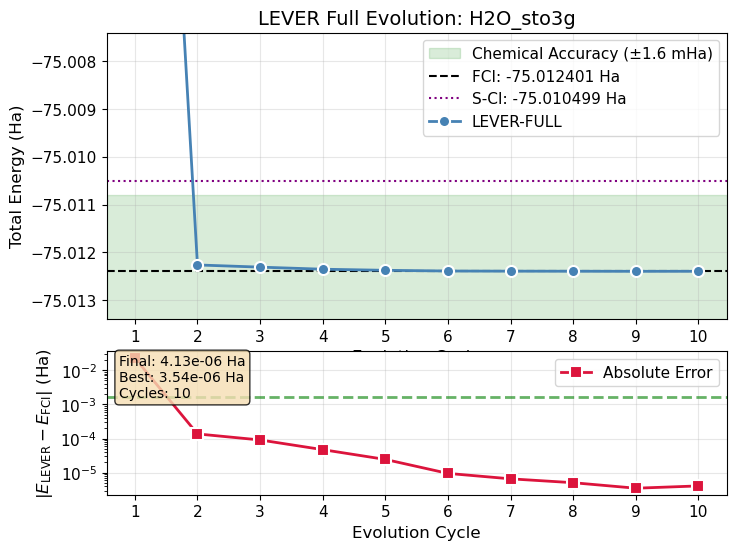

In [7]:
# Copyright 2025 The LEVER Authors - All rights reserved.
# SPDX-License-Identifier: Apache-2.0

"""
Full Hamiltonian evolution for LEVER wavefunction optimization.

Predict-filter-solve workflow: generate connected space C, filter to C' via
amplitude screening, optimize in S∪C' with exact Hamiltonian, select top-K
determinants for next iteration.

File: examples/run_evolution_full.py
Author: Zheng (Alex) Che, email: wsmxcz@gmail.com
Date: January, 2025
"""

from __future__ import annotations

import time
from pathlib import Path
from typing import Any

import jax
print("JAX detected devices:", jax.devices())
jax.config.update("jax_platforms", "cuda")
jax.config.update("jax_log_compiles", False)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import scipy.sparse as sp
import scipy.sparse.linalg as spla

import lever
from lever import engine, core


# ========================================================================
# Configuration
# ========================================================================

CONFIG = {
    'fcidump_path': "../benchmark/FCIDUMP/H2O_sto3g.FCIDUMP",
    'n_orbitals': 7,
    'n_alpha': 5,
    'n_beta': 5,
    'seed': 42,
    'learning_rate': 5e-4,
    'num_cycles': 10,
    'N_sdets': 20,           # S-space size for next iteration
    'N_cdets': 300,          # C'-space size (filtered from C)
    'steps_per_cycle': 200,
    'report_interval': 50,
    'compute_t_space': True,
}

ENGINE_CONFIG = engine.EngineConfig(
    compute_dtype=jnp.float64,
    energy_mode=engine.EnergyMode.FULL,  # Use exact Hamiltonian
    grad_mode=engine.GradMode.FULL,      # Compute full gradient
)


# ========================================================================
# Core Functions
# ========================================================================

def get_hf_determinant(n_orb: int, n_a: int, n_b: int) -> np.ndarray:
    """Construct HF reference: |HF⟩ = |1...n_α⟩ ⊗ |1...n_β⟩ as bit string."""
    return np.array([[(1 << n_a) - 1, (1 << n_b) - 1]], dtype=np.uint64)


def compute_fci_energy(
    int_ctx: lever.IntCtx,
    n_orb: int,
    n_a: int,
    n_b: int,
) -> float:
    """
    Exact ground state via FCI Hamiltonian diagonalization.
  
    Returns electronic energy (excludes E_nuc) using sparse Lanczos algorithm.
    """
    fci_dets = core.gen_fci_dets(n_orb, n_a, n_b)
    ham_fci, _, _ = engine.hamiltonian.get_ham_proxy(
        S_dets=fci_dets, int_ctx=int_ctx, n_orbitals=n_orb, use_heatbath=False
    )

    H_csr = sp.coo_matrix(
        (ham_fci.vals, (ham_fci.rows, ham_fci.cols)), shape=ham_fci.shape
    ).tocsr()
    H_csr.sum_duplicates()

    evals, _ = spla.eigsh(H_csr, k=1, which='SA', tol=1e-15, ncv=200, maxiter=3000)
    return float(evals[0])

def diagonalize_hamiltonian(ham: Any, e_nuc: float) -> float:
    """CI reference via Hamiltonian diagonalization. Returns total energy."""
    H_csr = sp.coo_matrix(
        (ham.vals, (ham.rows, ham.cols)), shape=ham.shape
    ).tocsr()
    H_csr.sum_duplicates()

    ncv = min(200, H_csr.shape[0] - 1)
    evals, _ = spla.eigsh(H_csr, k=1, which='SA', tol=1e-12, ncv=ncv, maxiter=3000)
    return float(evals[0]) + e_nuc


def filter_determinants_by_amplitude(
    variables: Any,
    logpsi_fn: callable,
    dets: np.ndarray,
    n_orb: int,
    top_k: int,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Select top-K determinants by wavefunction amplitude.
  
    Args:
        variables: Model parameters
        logpsi_fn: Log-amplitude function
        dets: Determinant array to filter
        n_orb: Number of orbitals
        top_k: Number of determinants to select
  
    Returns:
        (selected_dets, amplitudes): Selected determinants and their amplitudes
    """
    # Forward pass to compute amplitudes
    det_vecs = engine.utils.masks_to_vecs(jnp.asarray(dets), n_orb)
    log_psi = logpsi_fn(variables, det_vecs)
    amplitudes = np.abs(np.array(jnp.exp(log_psi)))
  
    # Select top-K by absolute amplitude
    num_select = min(top_k, len(amplitudes))
    top_indices = np.argsort(amplitudes)[-num_select:]
  
    return dets[top_indices], amplitudes[top_indices]


def compute_t_space_energy(
    variables: Any,
    logpsi_fn: callable,
    ham_tt: Any,
    t_dets: np.ndarray,
    n_orb: int,
    e_nuc: float,
) -> tuple[float, float]:
    """
    Evaluate energy in T = S ∪ C' space.
  
    Args:
        variables: Model parameters
        logpsi_fn: Log-amplitude function
        ham_tt: Full T-space Hamiltonian
        t_dets: T-space determinants
        n_orb: Number of orbitals
        e_nuc: Nuclear repulsion energy
  
    Returns:
        (E_variational, E_CI): Both include E_nuc
    """
    # Variational energy
    t_vecs = engine.utils.masks_to_vecs(jnp.asarray(t_dets), n_orb)
    log_psi_t = logpsi_fn(variables, t_vecs)
    psi_t = np.array(jnp.exp(log_psi_t))

    h_psi = engine.kernels.coo_matvec(
        ham_tt.rows, ham_tt.cols, ham_tt.vals, psi_t, len(t_dets)
    )
    e_var = np.vdot(psi_t, h_psi).real / np.vdot(psi_t, psi_t).real

    # CI energy
    e_ci = diagonalize_hamiltonian(ham_tt, 0.0)

    return e_var + e_nuc, e_ci + e_nuc


# ========================================================================
# Optimization
# ========================================================================

def _create_jitted_step_fn(
    logpsi_fn: callable,
    ham_ss: Any,
    ham_sc: Any,
    ham_cc: Any,
    space_rep: Any,
    n_orb: int,
    e_nuc: float,
    optimizer: optax.GradientTransformation,
    engine_config: engine.EngineConfig,
):
    """Factory for JIT-compiled optimization step capturing static data."""

    def step_fn(variables: Any, opt_state: Any) -> tuple[Any, Any, float]:
        """Single optimization step with full Hamiltonian energy/gradient."""
        evaluator = engine.Evaluator(
            params=variables,
            logpsi_fn=logpsi_fn,
            ham_ss=ham_ss,
            ham_sc=ham_sc,
            ham_cc=ham_cc,
            space=space_rep,
            n_orbitals=n_orb,
            config=engine_config,
        )

        result = engine.compute_energy_and_gradient(evaluator)
        updates, new_opt_state = optimizer.update(result.gradient, opt_state, variables)
        new_variables = optax.apply_updates(variables, updates)

        return new_variables, new_opt_state, result.energy_elec + e_nuc

    return jax.jit(step_fn)


def run_optimization_cycle(
    variables: Any,
    logpsi_fn: callable,
    ham_ss: Any,
    ham_sc: Any,
    ham_cc: Any,
    space_rep: Any,
    n_orb: int,
    e_nuc: float,
    num_steps: int,
    lr: float,
    cycle_num: int,
    report_freq: int,
) -> tuple[Any, list[float]]:
    """Gradient descent with exact Hamiltonian in S∪C' space."""
    optimizer = optax.adamw(lr)
    opt_state = optimizer.init(variables)

    jitted_step = _create_jitted_step_fn(
        logpsi_fn, ham_ss, ham_sc, ham_cc, space_rep, n_orb, e_nuc, optimizer, ENGINE_CONFIG
    )

    energy_history = []
    for step in range(num_steps):
        variables, opt_state, total_energy = jitted_step(variables, opt_state)
        energy_history.append(float(total_energy))

        if (step + 1) % report_freq == 0:
            print(f"  Cycle {cycle_num} | Step {step+1:4d}/{num_steps} | E = {total_energy:.8f} Ha")

    return variables, energy_history


# ========================================================================
# Visualization
# ========================================================================

def create_convergence_plot(
    energy_hist: list[float],
    cycle_bounds: list[int],
    exact_energy: float,
    ci_energy: float | None,
    system_name: str,
) -> None:
    """Dual-panel plot: energy trajectory and logarithmic error convergence."""
    plt.rcParams.update({
        'font.size': 11,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'lines.linewidth': 2.0,
        'grid.alpha': 0.3,
    })

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(8, 6),
        height_ratios=[2, 1],
        gridspec_kw={'hspace': 0.15}
    )

    energy = np.array(energy_hist)
    cycle_end_steps = [b - 1 for b in cycle_bounds[1:]]
    cycle_end_energies = [energy[idx] for idx in cycle_end_steps]
    cycle_end_errors = [abs(e - exact_energy) for e in cycle_end_energies]

    chem_acc = 1.6e-3  # 1 kcal/mol
    cycle_indices = np.arange(1, len(cycle_end_steps) + 1)

    # Energy trajectory
    ax1.axhspan(
        exact_energy - chem_acc, exact_energy + chem_acc,
        alpha=0.15, color='green', label='Chemical Accuracy (±1.6 mHa)'
    )
    ax1.axhline(exact_energy, color='black', linestyle='--', linewidth=1.5,
                label=f'FCI: {exact_energy:.6f} Ha')
    if ci_energy:
        ax1.axhline(ci_energy, color='purple', linestyle=':', linewidth=1.5,
                    label=f'S-CI: {ci_energy:.6f} Ha')
    ax1.plot(cycle_indices, cycle_end_energies, 'o-', color='steelblue',
             markersize=8, markeredgecolor='white', markeredgewidth=1.5, label='LEVER-FULL')

    ax1.set_ylim(exact_energy - 1e-3, exact_energy + 5e-3)
    ax1.set_ylabel('Total Energy (Ha)')
    ax1.set_xlabel('Evolution Cycle')
    ax1.set_title(f'LEVER Full Evolution: {system_name}')
    ax1.legend(loc='upper right')
    ax1.grid(True)
    ax1.set_xticks(cycle_indices)

    # Logarithmic error
    ax2.semilogy(cycle_indices, cycle_end_errors, 's-', color='crimson',
                 markersize=8, markeredgecolor='white', markeredgewidth=1.5,
                 label='Absolute Error')
    ax2.axhline(chem_acc, color='green', linestyle='--', alpha=0.6)

    ax2.set_xlabel('Evolution Cycle')
    ax2.set_ylabel(r'$|E_{\mathrm{LEVER}} - E_{\mathrm{FCI}}|$ (Ha)')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    ax2.set_xticks(cycle_indices)

    stats = (f'Final: {cycle_end_errors[-1]:.2e} Ha\n'
             f'Best: {min(cycle_end_errors):.2e} Ha\n'
             f'Cycles: {len(cycle_end_steps)}')
    ax2.text(0.02, 0.98, stats, transform=ax2.transAxes, verticalalignment='top',
             fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.show()


# ========================================================================
# Main Workflow
# ========================================================================

def main() -> None:
    cfg = CONFIG
    print(f"\n{'═' * 70}")
    print(f"LEVER {lever.__version__} - Full Hamiltonian Evolution".center(70))
    print(f"{'═' * 70}\n")

    # System setup
    int_ctx = lever.IntCtx(cfg['fcidump_path'], cfg['n_orbitals'])
    int_ctx.hb_prepare()
    e_nuc = int_ctx.get_e_nuc()
    system_name = Path(cfg['fcidump_path']).stem

    print(f"System: {system_name}")
    print(f"  Orbitals: {cfg['n_orbitals']} | α: {cfg['n_alpha']} | β: {cfg['n_beta']}")
    print(f"  E_nuc: {e_nuc:.8f} Ha\n")

    # Model initialization
    model = lever.models.Backflow(
        n_orbitals=cfg['n_orbitals'],
        n_alpha=cfg['n_alpha'],
        n_beta=cfg['n_beta'],
        seed=cfg['seed'],
        generalized=True,
        hidden_dims=(256, ),
        param_dtype=jnp.complex64
    )
    variables = model.variables

    print(f"Model: {model.__class__.__name__} (Holomorphic: {model.is_holo})")
    print(f"  Cycles: {cfg['num_cycles']} | N_sdets: {cfg['N_sdets']} | "
          f"N_cdets: {cfg['N_cdets']}")
    print(f"  Steps/cycle: {cfg['steps_per_cycle']} | Learning rate: {cfg['learning_rate']:.4f}")
    print(f"  T-space eval: {'On' if cfg['compute_t_space'] else 'Off'}\n")

    # Evolution loop
    s_dets = get_hf_determinant(cfg['n_orbitals'], cfg['n_alpha'], cfg['n_beta'])
    full_history = []
    cycle_boundaries = [0]
    final_ham_tt = None
    final_t_dets = None

    t_start = time.time()
    print(f"{'─' * 70}")
    print("Evolution Progress")
    print(f"{'─' * 70}")

    for cycle in range(cfg['num_cycles']):
        # Step 1: Generate full connected space C
        c_dets = core.gen_excited_dets(
            ref_dets=s_dets,
            n_orb=cfg['n_orbitals'],
            int_ctx=int_ctx,
            use_heatbath=True,
            eps1=1e-5
        )
      
        # Step 2: Filter C → C' via amplitude screening
        c_prime_dets, c_amplitudes = filter_determinants_by_amplitude(
            variables=variables,
            logpsi_fn=model.log_psi,
            dets=c_dets,
            n_orb=cfg['n_orbitals'],
            top_k=cfg['N_cdets'],
        )
      
        print(f"\nCycle {cycle + 1}/{cfg['num_cycles']} | "
              f"S: {len(s_dets)} | C: {len(c_dets)} → C': {len(c_prime_dets)}")

        # Step 3: Build exact Hamiltonian in S ∪ C'
        ham_ss, ham_sc_prime, ham_cc_prime, space_rep = engine.hamiltonian.get_ham_full(
            S_dets=s_dets,
            C_prime_dets=c_prime_dets,
            int_ctx=int_ctx,
            n_orbitals=cfg['n_orbitals'],
        )

        print(f"  Hamiltonian: H_SS: {len(ham_ss.vals):,} | "
              f"H_SC': {len(ham_sc_prime.vals):,} | H_C'C': {len(ham_cc_prime.vals):,}")

        # Save for final T-space evaluation
        if cycle == cfg['num_cycles'] - 1:
            t_dets = np.concatenate([s_dets, c_prime_dets])
            # Construct full T-space Hamiltonian for CI/variational evaluation
            final_ham_tt, _, _ = engine.hamiltonian.get_ham_proxy(
                S_dets=t_dets, int_ctx=int_ctx, n_orbitals=cfg['n_orbitals'],
                use_heatbath=False
            )
            final_t_dets = t_dets

        # Step 4: Optimize with exact Hamiltonian
        variables, cycle_history = run_optimization_cycle(
            variables=variables,
            logpsi_fn=model.log_psi,
            ham_ss=ham_ss,
            ham_sc=ham_sc_prime,
            ham_cc=ham_cc_prime,
            space_rep=space_rep,
            n_orb=cfg['n_orbitals'],
            e_nuc=e_nuc,
            num_steps=cfg['steps_per_cycle'],
            lr=cfg['learning_rate'],
            cycle_num=cycle + 1,
            report_freq=cfg['report_interval'],
        )

        full_history.extend(cycle_history)
        cycle_boundaries.append(len(full_history))
        print(f"  Final: {cycle_history[-1]:.8f} Ha")

        # Step 5: Update S-space for next cycle (select from S ∪ C')
        if cycle < cfg['num_cycles'] - 1:
            evaluator = engine.Evaluator(
                params=variables,
                logpsi_fn=model.log_psi,
                ham_ss=ham_ss,
                ham_sc=ham_sc_prime,
                ham_cc=ham_cc_prime,
                space=space_rep,
                n_orbitals=cfg['n_orbitals'],
                config=ENGINE_CONFIG,
            )
            psi_s, psi_c = evaluator.wavefunction

            # Select top-K from S ∪ C' based on amplitude
            all_amplitudes = np.abs(np.concatenate([psi_s, psi_c]))
            all_dets = np.concatenate([s_dets, c_prime_dets])

            num_select = min(cfg['N_sdets'], len(all_amplitudes))
            top_indices = np.argsort(all_amplitudes)[-num_select:]
            s_dets = all_dets[top_indices]

    elapsed = time.time() - t_start
    final_energy = full_history[-1]

    # Final analysis
    print(f"\n{'─' * 70}")
    print("Final Analysis")
    print(f"{'─' * 70}\n")

    # FCI reference
    e_fci_elec = compute_fci_energy(int_ctx, cfg['n_orbitals'], cfg['n_alpha'], cfg['n_beta'])
    e_fci = e_fci_elec + e_nuc

    print(f"Reference Energies:")
    print(f"  FCI: {e_fci:.8f} Ha")

    # S-space CI (final cycle)
    e_ci_s = None
    if ham_ss is not None:
        e_ci_s = diagonalize_hamiltonian(ham_ss, e_nuc)
        print(f"  S-space CI: {e_ci_s:.8f} Ha (gap: {(e_ci_s - e_fci) * 1e3:+.4f} mHa)")

    # T-space evaluation (S ∪ C')
    if cfg['compute_t_space'] and final_ham_tt is not None:
        e_t_var, e_t_ci = compute_t_space_energy(
            variables=variables,
            logpsi_fn=model.log_psi,
            ham_tt=final_ham_tt,
            t_dets=final_t_dets,
            n_orb=cfg['n_orbitals'],
            e_nuc=e_nuc,
        )
        t_size = len(final_t_dets)
        print(f"  T-space CI: {e_t_ci:.8f} Ha | Size: {t_size} (gap: {(e_t_ci - e_fci) * 1e3:+.4f} mHa)")

    print(f"  LEVER Final Opt: {final_energy:.8f} Ha")
    print(f"  Error vs FCI: {(final_energy - e_fci) * 1e3:+.4f} mHa")
    print(f"  Evolution time: {elapsed:.2f} s\n")

    # Visualization
    create_convergence_plot(full_history, cycle_boundaries, e_fci, e_ci_s, system_name)


if __name__ == "__main__":
    main()